### Import Libaries

In [1]:
%matplotlib inline
import os
from tqdm import tqdm

import cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchinfo import summary
from torchmetrics.classification import BinaryConfusionMatrix

from utilities import AITEXPatched
from model_architectures import BinaryClassifier

c:\compute\envs\fdd\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\compute\envs\fdd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Data

In [2]:
# Define paths
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
model_dir = os.path.join(root, "models")
data_dir = os.path.join(root, "data")
aitex_dir = os.path.join(data_dir, "aitex")

# Load dataset with transforms and split
transform = transforms.Compose([
    transforms.Resize((224, 224))
])
data = AITEXPatched(aitex_dir, transform=transform, greyscale=True)#, normal_only=True)
num_samples = len(data)
train_samples = int(num_samples * 0.95)
val_samples = num_samples - train_samples
train, val = random_split(data, [train_samples, val_samples])


In [41]:
img, label = train[0]
img = img.numpy().reshape(224, 224)
img =cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

c:\compute\envs\fdd\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


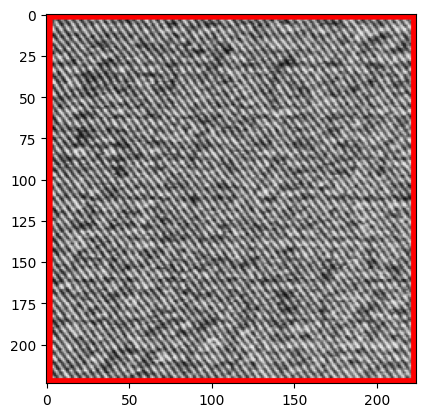

In [42]:
thickness = 6
plt.imshow(cv2.rectangle(img, (0, 0), (224, 224), (255, 0, 0), thickness))

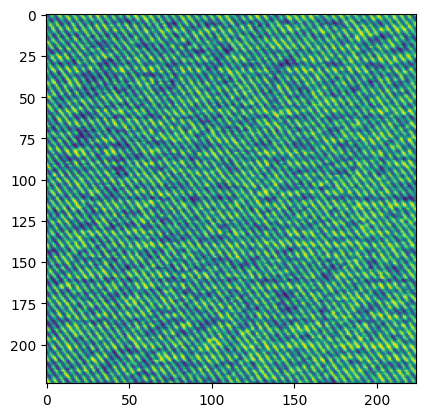

In [10]:
plt.imshow(img)

In [5]:
# Apply weighting due to class imbalance
class_counts = [data.has_defect.count(c) for c in range(2)]
total_samples = sum(class_counts)
class_weights = [total_samples / (2 * count) for count in class_counts]
class_weights = torch.FloatTensor(class_weights).cuda()

sample_weights = [0] * len(train)
for idx, (img, label) in enumerate(train):
    sample_weights[idx] = class_weights[label]

# Create data loaders with weighted sampling
bs = 16
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_loader = DataLoader(train, batch_size=bs, sampler=train_sampler)#, num_workers=4)
val_loader = DataLoader(val, batch_size=bs, shuffle=False)#, num_workers=4)

c:\compute\envs\fdd\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Define Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier().to(device)

# Use binary crossentropy as our loss function (sigmoidal output with
# weighting on the loss)
loss_fn = nn.BCELoss(weight=class_weights[-1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, labels):
    """Calculate accuracy from og and pred labels."""
    predictions = (outputs >= 0.5).float()
    correct = (predictions == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

### Train Model

In [26]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    valid_accuracy = 0.0
    
    # Train the model
    model.train()
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        for images, labels in tepoch:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            train_accuracy += calculate_accuracy(outputs, labels)
    
    # Validate the model
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_loss += loss.item() * images.size(0)
            valid_accuracy += calculate_accuracy(outputs, labels)
    
    # Calculate average losses and accuracy
    train_loss = train_loss / len(train)
    train_accuracy = train_accuracy / len(train_loader)
    valid_loss = valid_loss / len(val)
    valid_accuracy = valid_accuracy / len(val_loader)
    
    # Print progress
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")


100%|==========| 234/234 [00:07<00:00, 30.04batch/s]


Epoch: 1/5, Train Loss: 0.0015, Train Accuracy: 1.0000, Valid Loss: 8.3738, Valid Accuracy: 0.9567


100%|==========| 234/234 [00:07<00:00, 29.99batch/s]


Epoch: 2/5, Train Loss: 0.0006, Train Accuracy: 1.0000, Valid Loss: 8.3703, Valid Accuracy: 0.9567


100%|==========| 234/234 [00:07<00:00, 30.03batch/s]


Epoch: 3/5, Train Loss: 0.0005, Train Accuracy: 1.0000, Valid Loss: 8.3802, Valid Accuracy: 0.9567


100%|==========| 234/234 [00:07<00:00, 30.02batch/s]


Epoch: 4/5, Train Loss: 0.0004, Train Accuracy: 1.0000, Valid Loss: 8.6600, Valid Accuracy: 0.9567


100%|==========| 234/234 [00:07<00:00, 30.03batch/s]


Epoch: 5/5, Train Loss: 0.0003, Train Accuracy: 1.0000, Valid Loss: 8.8433, Valid Accuracy: 0.9567


In [29]:
torch.save(model.state_dict(), os.path.join(model_dir, "bigger_binary_F1_0.98.pth"))

In [6]:
# Reload trained model
model_path = os.path.join(model_dir, "bigger_binary_F1_0.98.pth")
model = BinaryClassifier()
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
 

### Quick Validation

In [7]:
# Get predictions for full dataset
model.eval()

y_true = []
y_pred = []
for img, label in data:
    res = model(img.reshape((1, 1, 224, 224)).cuda())
    y_true.append(label)
    y_pred.append(int(res.cpu().detach() >= 0.5))


F1 Score:  0.9750692520775623


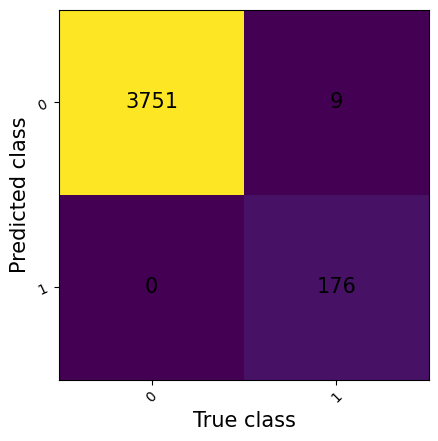

In [8]:
bcm = BinaryConfusionMatrix()
bcm.update(torch.Tensor(y_true), torch.Tensor(y_pred))
bcm.plot()

print("F1 Score: ", f1_score(y_true, y_pred))